Link to colab file: https://colab.research.google.com/drive/14YeTM5NqyFLjwfRKXPxmNvVasyh9IC9e?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rsync -ah --progress /content/drive/MyDrive/NOTEEVENTS.csv.gz /content/
!rsync -ah --progress /content/drive/MyDrive/DIAGNOSES_ICD.csv.gz /content/

sending incremental file list
NOTEEVENTS.csv.gz
          1.17G 100%   93.02MB/s    0:00:11 (xfr#1, to-chk=0/1)
sending incremental file list
DIAGNOSES_ICD.csv.gz
          4.72M 100%   68.73MB/s    0:00:00 (xfr#1, to-chk=0/1)


In [ ]:
!pip install scispacy
!pip install spacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_ner_bc5cdr_md: filename=en_ner_bc5cdr_md-0.5.4-py3-none-any.whl size=119787678 sha256=588f9bb523c332a17303ddda2607b0b530bfa1f1a6b014a817b2a9f165eda8c7
  Stored in directory: /root/.cache/pip/wheels/6e/a6/d6/bd15a41e2ff02a62f0a0a48dddbc07d048307db7199a1538f7
Successfully built en_ner_bc5cdr_md


In [ ]:
import pandas as pd
import spacy
import scispacy
from scispacy.linking import EntityLinker
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
file_path = "NOTEEVENTS.csv.gz"
notes_df = pd.read_csv(file_path, usecols=['TEXT', 'CATEGORY', 'HADM_ID'])

In [ ]:
icd_code = '40301'  # Hypertensive chronic kidney disease
diagnosis_df = pd.read_csv("DIAGNOSES_ICD.csv.gz", usecols=['HADM_ID', 'ICD9_CODE'])

In [ ]:
notes_df.merge(diagnosis_df[diagnosis_df['ICD9_CODE'] == icd_code], on='HADM_ID')[:500]

,HADM_ID,CATEGORY,TEXT,ICD9_CODE
0,186931.0,Discharge summary,Admission Date: [**2194-5-8**] D...,40301
1,136706.0,Discharge summary,Admission Date: [**2194-8-15**] ...,40301
2,193749.0,Discharge summary,Admission Date: [**2152-5-26**] ...,40301
3,121836.0,Discharge summary,Admission Date: [**2173-4-26**] ...,40301
4,188518.0,Discharge summary,Admission Date: [**2154-6-24**] Dischar...,40301
...,...,...,...,...
495,108409.0,ECG,Sinus rhythm. Minimal ST segment elevations a...,40301
496,108409.0,ECG,Sinus tachycardia. Inferior PR segment depres...,40301
497,121696.0,ECG,Sinus rhythm\nProlonged QT interval\nPossible ...,40301
498,121696.0,ECG,Sinus rhythm. Prolonged QTc interval. Left ven...,40301


In [ ]:
icd9_code = '40301'   # Hypertensive chronic kidney disease
diagnosis_df = pd.read_csv("DIAGNOSES_ICD.csv.gz", usecols=['HADM_ID', 'ICD9_CODE'])
relevant_notes = notes_df.merge(diagnosis_df[diagnosis_df['ICD9_CODE'] == icd9_code], on='HADM_ID')[:500]


nlp_spacy = spacy.load("en_core_web_sm")  # Standard SpaCy model



In [ ]:
def extract_entities_spacy(text):
    doc = nlp_spacy(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

relevant_notes['Entities_Spacy'] = relevant_notes['TEXT'].apply(lambda x: extract_entities_spacy(str(x)))




In [ ]:
text = "Patient admitted on 10/05/2023 for fever"
print(extract_entities_spacy(text))

[('10/05/2023', 'DATE')]


In [ ]:
import spacy

nlp = spacy.load("en_ner_bc5cdr_md")

def extract_entities_scispacy(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

text = "Patient diagnosed with pneumonia and prescribed azithromycin."
print(extract_entities_scispacy(text))

relevant_notes['Entities_SciSpacy'] = relevant_notes['TEXT'].dropna().apply(lambda x: extract_entities_scispacy(str(x)))


[('pneumonia', 'DISEASE'), ('azithromycin', 'CHEMICAL')]


In [ ]:
relevant_notes['Entities_Spacy'][0]

[('2194-5-8', 'DATE'),
 ('2194-5-14', 'DATE'),
 ('Lisinopril', 'PERSON'),
 ('1865', 'DATE'),
 ('1862', 'DATE'),
 ('86', 'DATE'),
 ('F', 'PRODUCT'),
 ('CRI', 'ORG'),
 ('CHF', 'ORG'),
 ('3 days', 'DATE'),
 ('BP', 'ORG'),
 ('220', 'CARDINAL'),
 ('SOB', 'ORG'),
 ('SOB', 'ORG'),
 ('202/40', 'CARDINAL'),
 ('5.9', 'CARDINAL'),
 ('30', 'CARDINAL'),
 ('40', 'CARDINAL'),
 ('IV', 'GPE'),
 ('0.3', 'CARDINAL'),
 ('750', 'CARDINAL'),
 ('1', 'CARDINAL'),
 ('98.3', 'CARDINAL'),
 ('226/68', 'CARDINAL'),
 ('68 90%', 'PERCENT'),
 ('mid\n80s', 'DATE'),
 ('96%', 'PERCENT'),
 ('40', 'CARDINAL'),
 ('100', 'CARDINAL'),
 ('IV', 'GPE'),
 ('Diuril', 'PERSON'),
 ('Renal', 'ORG'),
 ('UOP 350cc', 'ORG'),
 ('MICU', 'ORG'),
 ('99%', 'PERCENT'),
 ('MICU', 'ORG'),
 ('Overnight', 'TIME'),
 ('110s/120s', 'ORDINAL'),
 ('5', 'CARDINAL'),
 ('O2', 'CARDINAL'),
 ('170s', 'PERSON'),
 ('PCP', 'ORG'),
 ('w/ RLL PNA', 'ORG'),
 ('PCP', 'ORG'),
 ('10 days', 'DATE'),
 ('about 4 weeks ago', 'DATE'),
 ('3 weeks', 'DATE'),
 ('1860', 'D

In [ ]:
relevant_notes['Entities_SciSpacy'][0]

[('Lisinopril', 'CHEMICAL'),
 ('Nesiritide', 'CHEMICAL'),
 ('Shortness of breath', 'DISEASE'),
 ('nephrotic CRI', 'DISEASE'),
 ('renal artery stenosis', 'DISEASE'),
 ('CHF', 'DISEASE'),
 ('hypertensive', 'DISEASE'),
 ('heart failure', 'DISEASE'),
 ('SOB', 'DISEASE'),
 ('chest pain', 'DISEASE'),
 ('K', 'CHEMICAL'),
 ('kayexalate', 'CHEMICAL'),
 ('lasix', 'CHEMICAL'),
 ('clonidine', 'CHEMICAL'),
 ('dyspneic', 'DISEASE'),
 ('lasix', 'CHEMICAL'),
 ('nitrates', 'CHEMICAL'),
 ('morphine', 'CHEMICAL'),
 ('Appeared', 'DISEASE'),
 ('CP', 'CHEMICAL'),
 ('pain', 'DISEASE'),
 ('clonidine', 'CHEMICAL'),
 ('hydralazine', 'CHEMICAL'),
 ('edema', 'DISEASE'),
 ('O2', 'CHEMICAL'),
 ('PCP', 'CHEMICAL'),
 ('PCP', 'CHEMICAL'),
 ('levofloxacin', 'CHEMICAL'),
 ('cough', 'DISEASE'),
 ('chest pain', 'DISEASE'),
 ('Renal artery stenosis', 'DISEASE'),
 ('stenosis', 'DISEASE'),
 ('R renal artery, L renal artery', 'CHEMICAL'),
 ('proteinuria', 'DISEASE'),
 ('renal artery stenosis', 'DISEASE'),
 ('Colon cancer', 'D

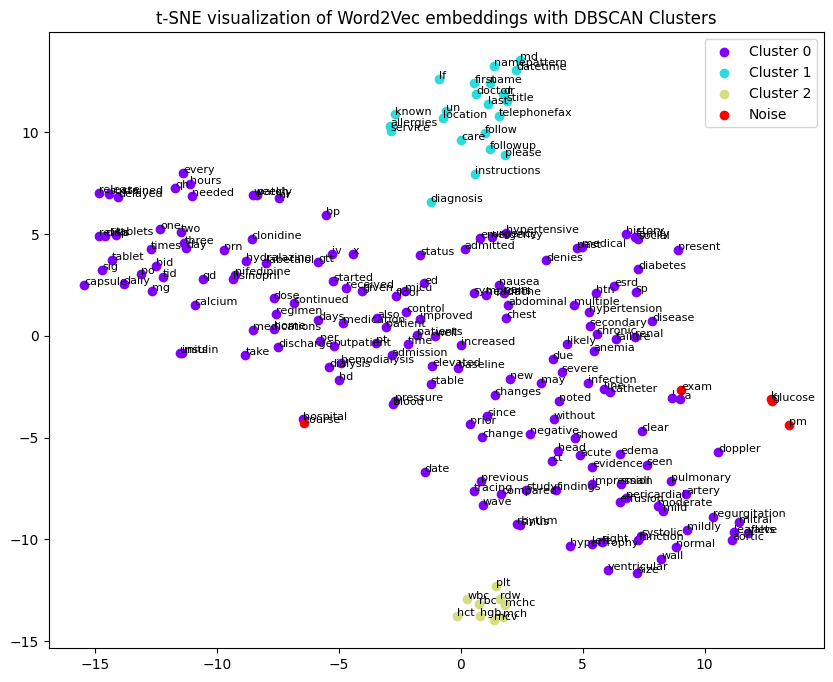

In [ ]:
import nltk
nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

stop_words = set(stopwords.words('english'))


def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.lower().split()
    return [word for word in words if word not in stop_words]


relevant_notes['cleaned_TEXT'] = relevant_notes['TEXT'].dropna().apply(clean_text)


sentences = relevant_notes['cleaned_TEXT'].tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=10, workers=4)


words = list(word2vec_model.wv.index_to_key)[:200]
word_vectors = np.array([word2vec_model.wv[word] for word in words])

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)


dbscan = DBSCAN(eps=2.5, min_samples=5).fit(word_vectors_2d)
labels = dbscan.labels_

# Plot t-SNE with Clusters
plt.figure(figsize=(10, 8))
unique_labels = set(labels)

colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    cluster_points = word_vectors_2d[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=f'Cluster {label}' if label != -1 else 'Noise')

for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=8)

plt.title("t-SNE visualization of Word2Vec embeddings with DBSCAN Clusters")
plt.legend()
plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load BlueBERT Model
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")
model = AutoModel.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")

def get_bluebert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

relevant_notes['BlueBERT_Embedding'] = relevant_notes['TEXT'].apply(lambda x: get_bluebert_embedding(str(x)))

In [ ]:
relevant_notes['BlueBERT_Embedding']

,BlueBERT_Embedding
0,"[-0.11351767, 0.09354286, 0.1269667, -0.018290..."
1,"[0.061230153, 0.06965853, 0.14467606, 0.062284..."
2,"[0.13775562, 0.10224091, 0.12923335, -0.111200..."
3,"[0.012953132, 0.064112656, 0.14425749, -0.0034..."
4,"[-0.28242743, -0.049746767, 0.015910702, -0.04..."
...,...
495,"[-0.4839048, -0.10663242, 0.060374174, -0.4248..."
496,"[-0.20749338, -0.10931938, 0.10405903, -0.4266..."
497,"[-0.04583359, -0.034879733, 0.1935586, -0.4459..."
498,"[-0.11775609, -0.152841, 0.07810093, -0.449902..."
